# Demo example: Using a Google Earth engine

This example is the continuation of the previous example: [Using a Dataset](https://vergauwenthomas.github.io/MetObs_toolkit/examples/doc_example.html). This example serves as a demonstration on how to get meta-data from the Google Earth Engine (GEE). 

Before proceeding, make sure you have **setup a google developers accound and a GEE project**. See [Using Google Earth Engine](https://vergauwenthomas.github.io/MetObs_toolkit/gee_authentication.html) for a detailed description on this.

## Create your Dataset

Create a dataset with the demo data.

In [3]:
import metobs_toolkit

your_dataset = metobs_toolkit.Dataset()
your_dataset.update_settings(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

your_dataset.import_data_from_file()

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/gap.py:777: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  missing_timestamp_series = pd.concat(


## Extracting LCZ from GEE

Here an example on how to extract the Local Climate Zone (LCZ) information of your stations. First we take a look on what is present in the metadata of the dataset. 

In [4]:
your_dataset.metadf.head()

,network,lat,lon,lcz,call_name,location,geometry,assumed_import_frequency,dataset_resolution
name,,,,,,,,,
vlinder01,Vlinder,50.980438,3.815763,NaN,Proefhoeve,Melle,POINT (3.81576 50.98044),0 days 00:05:00,0 days 00:05:00
vlinder02,Vlinder,51.022379,3.709695,NaN,Sterre,Gent,POINT (3.70969 51.02238),0 days 00:05:00,0 days 00:05:00
vlinder03,Vlinder,51.324583,4.952109,NaN,Centrum,Turnhout,POINT (4.95211 51.32458),0 days 00:05:00,0 days 00:05:00
vlinder04,Vlinder,51.335522,4.934732,NaN,Stadsboerderij,Turnhout,POINT (4.93473 51.33552),0 days 00:05:00,0 days 00:05:00
vlinder05,Vlinder,51.052655,3.675183,NaN,Watersportbaan,Gent,POINT (3.67518 51.05266),0 days 00:05:00,0 days 00:05:00


In order to extract geospatial information for you stations, the **lat** and **lon** (latitude and longitude)
of your stations must be present in the metadf. If so, than geospatial
information will be extracted from GEE at these locations.

To extract the Local Climate Zones (LCZ's) of your stations:

In [5]:
lcz_values = your_dataset.get_lcz()
# The LCZ's for all your stations are extracted
print(lcz_values)

Enter verification code:  4/1AfJohXkBqVx-SiDLjHp0EcT3YtJknBUtns_FRt4_iovqEhWjro4LXbX41B0



Successfully saved authorization token.
name
vlinder01         Low plants (LCZ D)
vlinder02               Open midrise
vlinder03               Open midrise
vlinder04             Sparsely built
vlinder05              Water (LCZ G)
vlinder06    Scattered Trees (LCZ B)
vlinder07            Compact midrise
vlinder08            Compact midrise
vlinder09    Scattered Trees (LCZ B)
vlinder10            Compact midrise
vlinder11               Open lowrise
vlinder12              Open highrise
vlinder13            Compact midrise
vlinder14         Low plants (LCZ D)
vlinder15             Sparsely built
vlinder16              Water (LCZ G)
vlinder17    Scattered Trees (LCZ B)
vlinder18         Low plants (LCZ D)
vlinder19            Compact midrise
vlinder20            Compact midrise
vlinder21             Sparsely built
vlinder22         Low plants (LCZ D)
vlinder23         Low plants (LCZ D)
vlinder24        Dense Trees (LCZ A)
vlinder25              Water (LCZ G)
vlinder26               Open 

The first time, in each session, you are asked to authenticated by Google.
Select your google account and billing project that you have set up and accept the terms of condition.

*NOTE: For small datarequest the read-only scopes are sufficient, for large datarequests this is insufficient because the data will be written directly to your google Drive.*

The metadata of your dataset is also updated

In [6]:
print(your_dataset.metadf['lcz'].head())

name
vlinder01    Low plants (LCZ D)
vlinder02          Open midrise
vlinder03          Open midrise
vlinder04        Sparsely built
vlinder05         Water (LCZ G)
Name: lcz, dtype: object


To make a geospatial plot you can use the following method:

/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.9/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.9/site-packages/geopandas/plotting.py:715: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: title={'center': 'LCZ'}>

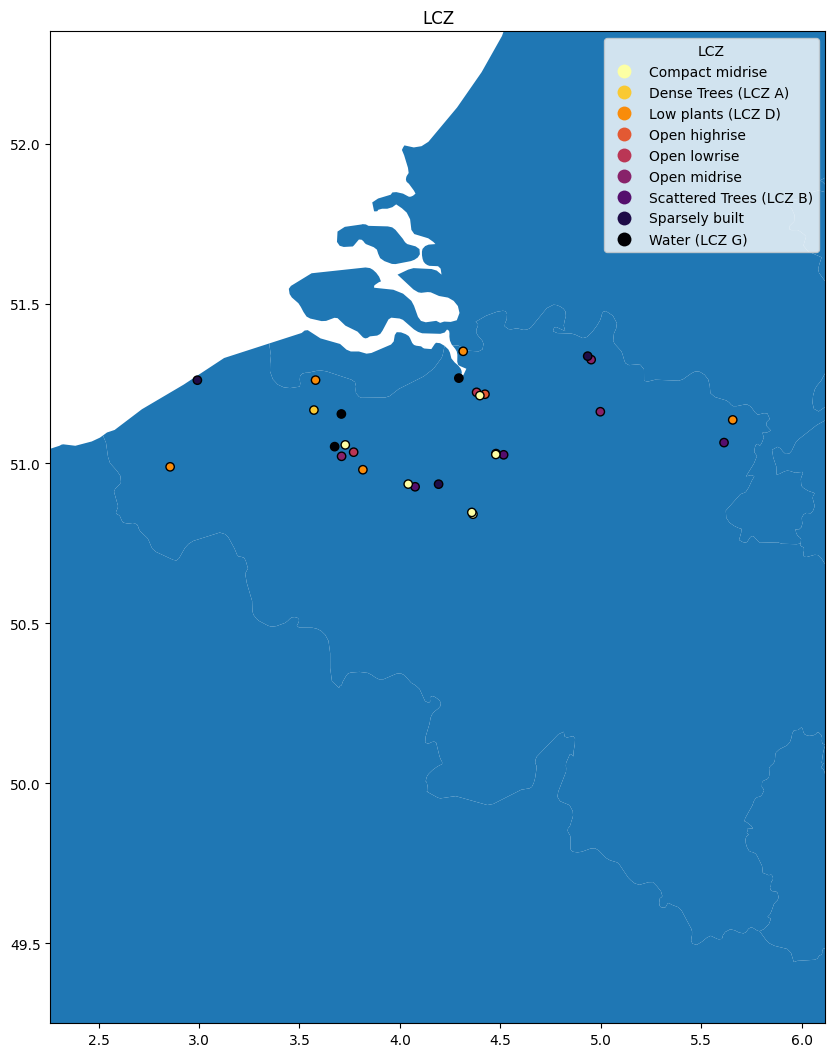

In [7]:
your_dataset.make_geo_plot(variable="lcz")

## Extracting other Geospatial information

Similar as LCZ extraction you can extract the altitude of the stations (from a digital elevation model):

In [8]:
altitudes = your_dataset.get_altitude() #The altitudes are in meters above sea level.
print(altitudes)

name
vlinder01    12
vlinder02     7
vlinder03    30
vlinder04    25
vlinder05     0
vlinder06     0
vlinder07     7
vlinder08     7
vlinder09    19
vlinder10    14
vlinder11     6
vlinder12     9
vlinder13    10
vlinder14     4
vlinder15    41
vlinder16     4
vlinder17    83
vlinder18    35
vlinder19    75
vlinder20    44
vlinder21    19
vlinder22     3
vlinder23     1
vlinder24    12
vlinder25    12
vlinder26    24
vlinder27    12
vlinder28     7
Name: altitude, dtype: int64


A more detailed description of the landcover/land use in the microenvironment can be extracted in the form of landcover fractions in a circular buffer for each station.

You can select to aggregate the landcoverclasses to water - pervious and impervious, or set aggregation to false to extract the landcoverclasses as present in the worldcover_10m dataset.

In [9]:
aggregated_landcover = your_dataset.get_landcover(
                                        buffers=[100, 250], # a list of bufferradii in meters
                                        aggregate=True #if True, aggregate landcover classes to the water, pervious and impervious.
                                        )

print(aggregated_landcover)

                            water  pervious  impervious
name      buffer_radius                                
vlinder01 100            0.000000  0.981781    0.018219
          250            0.000000  0.963635    0.036365
vlinder02 100            0.000000  0.428769    0.571231
          250            0.000000  0.535944    0.464056
vlinder03 100            0.000000  0.245454    0.754546
          250            0.000000  0.160831    0.839169
vlinder04 100            0.000000  0.979569    0.020431
          250            0.000000  0.881948    0.118052
vlinder05 100            0.446604  0.224871    0.328525
          250            0.242406  0.526977    0.230617
vlinder06 100            0.000000  1.000000    0.000000
          250            0.000000  0.995819    0.004181
vlinder07 100            0.000000  0.433034    0.566966
          250            0.002911  0.149681    0.847407
vlinder08 100            0.000000  0.029552    0.970448
          250            0.002911  0.030423    0

## Interactive plotting a GEE dataset

You can make an interactive spatial plot to visualize the stations spatially by using the [make_gee_plot()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.make_gee_plot).

In [13]:
spatial_map = your_dataset.make_gee_plot(gee_map='worldcover')
spatial_map